### Process single scan


In [1]:
# add parent directory to path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

    
%matplotlib inline

import matplotlib.pyplot as plt
    
from src.incompatibility_FEA import *

### Define input files & set up the simulation

In [2]:
#%% x_0 is the values of the stiffness tensor #MPa
# Crystal_Structure = 'HCP' order of stiffness values Stiffness: np.array((c11, c33, c44, c12, c13))
# Crystal_Structure = 'Cubic' order of stiffness values Stiffness: np.array((c11, c12, c44))

Crystal_Structure = 'HCP'
#Stiffness =  np.array(( 174800.0, 108900.0, 106700.0 ))
Stiffness = np.array((162400.0, 180700.0, 46700.0, 92000.0, 69000.0))
x_0 = {"Crystal_Structure": Crystal_Structure, "Stiffness": Stiffness}

mesh_dir   = '../mesh/'

mesh_name  = 'creep_0020'
data_dir   = '../data/'
output_dir = '../results/'

# Pick single step
step = '0020'

mesh_file      = mesh_dir + mesh_name
rotations_file = data_dir + 'rotations_0020.dat'
strains_file   = data_dir + 'strains_0020.dat'

eg = elasGrains(mesh_file,rotations_file,strains_file)

[-0.5 -0.5 -0.5]
[0.5 0.5 0.5]


### Prescribe the boundary conditions for the equilibrium problem

In [3]:
#%%
# Minimal "pointwise" boundary conditions
def boundary_0_0(x, on_boundary):
    tol = 1E-9
    return  (np.abs(x[0]-eg.dof_min[0]) < tol) and \
            (np.abs(x[1]-eg.dof_min[1]) < tol) and \
            (np.abs(x[2]-eg.dof_min[2]) < tol)

def boundary_1_0(x, on_boundary):
    tol = 1E-9
    return  (np.abs(x[0]-eg.dof_max[0]) < tol) and \
            (np.abs(x[1]-eg.dof_min[1]) < tol) and \
            (np.abs(x[2]-eg.dof_min[2]) < tol)    

def boundary_0_1(x, on_boundary):
    tol = 1E-9
    return  (np.abs(x[0]-eg.dof_min[0]) < tol) and \
            (np.abs(x[1]-eg.dof_min[1]) < tol) and \
            (np.abs(x[2]-eg.dof_max[2]) < tol)    

def boundary_lower(x, on_boundary):
    tol = 1E-9
    return (np.abs(x[1]-eg.dof_min[1]) < tol)

def boundary_upper(x, on_boundary):
    tol = 1E-9
    return (np.abs(x[1]-eg.dof_max[1]) < tol)

bc1  = DirichletBC(eg.V, Constant((0, 0, 0)), boundary_0_0, method="pointwise")
bc2a = DirichletBC(eg.V.sub(1), Constant(0), boundary_lower)
bc2b = DirichletBC(eg.V.sub(2), Constant(0), boundary_1_0, method="pointwise")
bc4  = DirichletBC(eg.V.sub(1), Constant(0.00405), boundary_upper)
eg.applyBC( [bc1, bc2a, bc2b, bc4] )

### Instantiate solution procedures for both equilibrium & incompatibility problems

In [4]:
#%%
%time eg.elasticity_problem(reuse_PC=True)

CPU times: user 130 ms, sys: 53.9 ms, total: 184 ms
Wall time: 129 ms


In [5]:
#%%
%time eg.incompatibility_problem(reuse_PC=True)

CPU times: user 1.35 s, sys: 524 ms, total: 1.88 s
Wall time: 1.25 s


### Iterative loop

In [6]:
#%%
# Convergence is improved if solution from a prior time step exists

# if int(step) > 0:
#     last_step = '%04d' % (int(step)-1)
#     X_filename = output_dir + "X_" + last_step + ".xdmf"
#     print('Taking initial X from checkpoint ' + X_filename)
#     fFile = XDMFFile(X_filename)
# #     fFile.read_checkpoint(ue,"ue")
#     X_i = Function(eg.TFS)
#     fFile.read_checkpoint(X_i,"X")
#     fFile.close()

#     X_init = X_i
# else:
#     X_init = None

# No prior solution is available
X_init = None


print('First equilibrium solve')
%time rsd = eg.solve_elas(x_0)

# save the strain from the original problem for development
eg.ref_strn = np.copy(eg.sim_strn)
eg.ref_avg = np.copy(eg.sim_avg)

### Development: will want to develop strain diff in routine contained in class ###

for n in range(3):
    cell_num_list = list((3*eg.cell_num)+n)
    eg.strain_diff_1.vector()[cell_num_list] = \
        eg.exp_strn[eg.subdomain_num,n]
    eg.strain_diff_2.vector()[cell_num_list] = \
        eg.exp_strn[eg.subdomain_num,3+n]
    eg.strain_diff_3.vector()[cell_num_list] = \
        eg.exp_strn[eg.subdomain_num,6+n]

if X_init:
    eg.X = X_init
else:
    print('First incompatibility solve')
    %time eg.X = eg.incompatibility_solve_cg()

e_inc_elas = project( sym(-eg.X), eg.TFS, solver_type="cg", preconditioner_type="ilu")

print('Second equilibrium solve')
%time res = eg.solve_elas(x_0,E_p=e_inc_elas)

# Cell to develop average of the latest simulation strain
s_avg = np.zeros((eg.grains.array().max(),9))
s_check = np.zeros((eg.grains.array().max(),9))

# Iterative loop 
last_res = 1e6
for nn in range(24):

    for grain_no in range(eg.grains.array().max()):
        # Grain numbering is 1 index origin
        cell_subset = eg.grains.array()==(grain_no+1)
        if np.any(cell_subset):
            s_avg[grain_no,:] = np.average(eg.sim_strn[cell_subset,:],
                                         axis=0,weights=eg.dVol[cell_subset])
        
    # Set up the potential for the curl problem
    # sim_avg has the volume-weighted average.  Develop a scaled correction,
    # to go in the rhs that has the same grain average as the hedm result

    for n in range(3):
        cell_num_list = list((3*eg.cell_num)+n)
        eg.strain_diff_1.vector()[cell_num_list] = \
            eg.exp_strn[eg.subdomain_num,n] + \
            (eg.sim_strn[eg.cell_num,n]-s_avg[eg.subdomain_num,n])
        eg.strain_diff_2.vector()[cell_num_list] = \
            eg.exp_strn[eg.subdomain_num,3+n] + \
            (eg.sim_strn[eg.cell_num,3+n]-s_avg[eg.subdomain_num,3+n])                  
        eg.strain_diff_3.vector()[cell_num_list] = \
            eg.exp_strn[eg.subdomain_num,6+n] + \
            (eg.sim_strn[eg.cell_num,6+n]-s_avg[eg.subdomain_num,6+n])            

    print('INCOMPATIBILITY')
    %time eg.X = eg.incompatibility_solve_cg()

#     print('PROJECT')
#     %time e_inc_elas = project( sym(-eg.X), eg.TFS, solver_type="cg", preconditioner_type="ilu")
    
    print('EQUILIBRIUM')
#     %time res = eg.solve_elas(x_0,E_p=e_inc_elas)
    # eg.X is symmetrized in forming RHS
    %time res = eg.solve_elas(x_0,E_p=-eg.X)
    
    if ( ((np.abs(res-last_res)/res) < 0.005) and (res<last_res) ):
        break

    last_res = res  

# To be deleted
# X_np = np.reshape(eg.X.vector().get_local(),(len(eg.grains.array()),9))

First equilibrium solve
0.03317517416246897
CPU times: user 12.1 s, sys: 9.08 s, total: 21.2 s
Wall time: 10.2 s
First incompatibility solve
CPU times: user 13.2 s, sys: 22.6 s, total: 35.8 s
Wall time: 8.47 s
Second equilibrium solve
0.025994766523329757
CPU times: user 5.31 s, sys: 5.72 s, total: 11 s
Wall time: 4.27 s
INCOMPATIBILITY
CPU times: user 12.5 s, sys: 22.7 s, total: 35.3 s
Wall time: 7.65 s
EQUILIBRIUM
0.024862067427101762
CPU times: user 5.38 s, sys: 5.85 s, total: 11.2 s
Wall time: 4.22 s
INCOMPATIBILITY
CPU times: user 12.7 s, sys: 23.1 s, total: 35.8 s
Wall time: 7.6 s
EQUILIBRIUM
0.024203412958051698
CPU times: user 5.35 s, sys: 5.94 s, total: 11.3 s
Wall time: 4.22 s
INCOMPATIBILITY
CPU times: user 12.7 s, sys: 23.1 s, total: 35.9 s
Wall time: 7.58 s
EQUILIBRIUM
0.023730811859859303
CPU times: user 5.26 s, sys: 6.09 s, total: 11.4 s
Wall time: 4.2 s
INCOMPATIBILITY
CPU times: user 13.1 s, sys: 21.7 s, total: 34.8 s
Wall time: 8.13 s
EQUILIBRIUM
0.023360272703804665


In [7]:
#%%
# Write out compatible and incompatible distortions

fFile = XDMFFile(output_dir + "ue_" + step + ".xdmf")
fFile.write_checkpoint (eg.ue,"ue")
fFile.close()

fFile = XDMFFile(output_dir + "X_" + step + ".xdmf")
fFile.write_checkpoint(eg.X,"X")
fFile.close()

### Comparison of extension strain with & w/o incompatibility

([<matplotlib.axis.XTick at 0x7f3207544a90>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

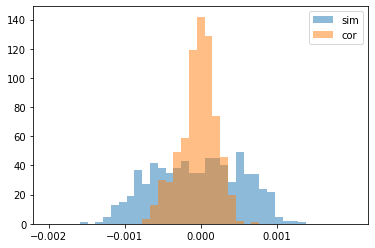

In [8]:
# before
idx = 4
before = eg.ref_avg[:,idx]-eg.exp_strn[:,idx]
#before = np.linalg.norm(sim_avg-exp_strn,axis=1)
before = before[~np.isnan(before)]
after = eg.sim_avg[:,idx]-eg.exp_strn[:,idx]
# after = np.linalg.norm(sim_avg_cor-exp_strn,axis=1)
after = after[~np.isnan(after)]

bins = np.linspace(-0.002, 0.002, 40)
plt.hist(before, bins, alpha=0.5, label='sim')
plt.hist(after, bins, alpha=0.5, label='cor')
plt.legend(loc='upper right')
plt.xticks(np.arange(-0.002, 0.002, step=0.001))